# 非极大值抑制


 非极大值抑制，简称为NMS算法。是一种获取局部最大值的有效方法。在3领域中，假设一个行向量的长度为w，从左向右，由第一个到第w个和其3领域中的数值进行比对。

如果某个i大于i+1并且小于i-1，则其为一个绝不最大值，同时也就意味着i+1不是一个局部最大值，所以将i移动2个步长，从i+2开始继续向后进行比较判断。如果某个i不满足上述条件，则将i+1，继续对i+1进行比对。当比对到最后一个w时，直接将w设置为局部最大值。算法如下图所示：

![](doc_imgs/03.jpg)


In [47]:
import numpy as np
import scipy
from scipy.ndimage import filters
%matplotlib inline
import matplotlib.pyplot as plt
import skimage as ski
import skimage.io as skio
import skimage.color as skcolor
from scipy.ndimage import measurements

In [80]:
src = skio.imread('../datas/f2.jpg')
gray = skcolor.rgb2gray(src)

In [11]:
def gradient(src):
    dstx = np.zeros_like(src)
    dsty = np.zeros_like(src)
    rows,cols = src.shape[0],src.shape[1]
#     print(dstx[0:rows-1,:].shape,src[0:rows-1,:].shape,src[1:rows,:].shape)
    dstx[0:rows-1,:] = src[0:rows-1,:] - src[1:rows,:]
    dsty[:,0:cols-1] = src[:,0:cols-1] - src[:,1:cols]
    return dstx,dsty

In [6]:
def gray_gradient(image):
    Gx, Gy = gradient(image)
    Gm = np.sqrt(Gx**2+Gy**2)
    Gd = np.arctan2(Gy, Gx)    
    Gd[Gd > 0.5*np.pi] -= np.pi
    Gd[Gd < -0.5*np.pi] += np.pi
    return Gm, Gd

In [7]:
## nonmaximum suppression
# Gm: gradient magnitudes
# Gd: gradient directions, -pi/2 to +pi/2
# return: nms, gradient magnitude if local max, 0 otherwise
def nonmaxsupress(Gm, Gd, th=1.0):
    nms = np.zeros(Gm.shape, Gm.dtype)   
    h,w = Gm.shape    
    for x in range(1, w-1):
        for y in range(1, h-1):            
            mag = Gm[y,x]
            if mag < th: continue        
            teta = Gd[y,x]            
            dx, dy = 0, -1      # abs(orient) >= 1.1781, teta < -67.5 degrees and teta > 67.5 degrees
            if abs(teta) <= 0.3927: dx, dy = 1, 0       # -22.5 <= teta <= 22.5
            elif teta < 1.1781 and teta > 0.3927: dx, dy = 1, 1     # 22.5 < teta < 67.5 degrees
            elif teta > -1.1781 and teta < -0.3927: dx, dy = 1, -1  # -67.5 < teta < -22.5 degrees            
            if mag > Gm[y+dy,x+dx] and mag > Gm[y-dy,x-dx]: nms[y,x] = mag    
    return nms

In [42]:
Gm,Gd = gray_gradient(gray)
mns = nonmaxsupress(Gm,Gd,0.15)
mns[mns > 0] = 1.0

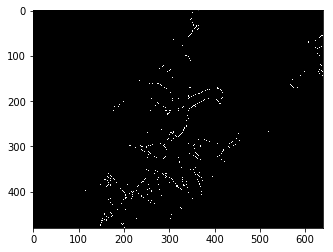

In [43]:
plt.imshow(mns,'gray')

In [28]:
print((mns == 0).all())

True


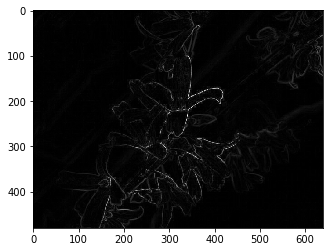

In [15]:
plt.imshow(Gm,'gray')

In [63]:
### hysteresis thresholding
def hysteresisThreshold(nms, thLow, thHigh, binaryEdge = True):
    labels, n = measurements.label(nms > thLow, structure=np.ones((3,3)))
    for i in range(1, n):
        upper = np.amax(nms[labels==i])
        if upper < thHigh: labels[labels==i] = 0
    if binaryEdge: return 255*(labels>0)        
    else: return nms*(labels>0)

In [64]:
def detect_gray(image, thLow, thHigh, binaryEdge=True):
    Gm, Gd = gray_gradient(image)
    #print 'Gm max:', Gm.max(), mean(Gm)
    nms = nonmaxsupress(Gm, Gd, th=thLow)
    #fr = getFractile(nms, th=1.0, fraction=0.30, bins=255)
    #print 'Fractile:', fr, thLow, thHigh
    edge = hysteresisThreshold(nms, thLow, thHigh, binaryEdge)    
    return edge, nms

In [71]:
dst,_ = detect_gray(gray,0.1,1.0)

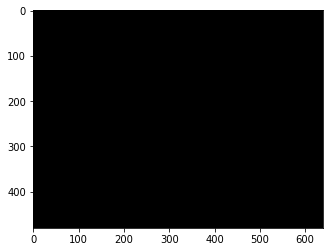

In [76]:
dst[dst > 0] = 1.0
plt.imshow(dst,'gray')

In [77]:
print((dst == 0).all())

False


In [78]:
print(dst)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
